Inspect HSC COSMOS blends with undetected/unmatched HST objects.

This notebook uses multiprofit's Rebuilder classes to plot blends in COSMOS.
These classes are meant to plot multiprofit parametric model fits but can be
used to plot data alone.

You will need to setup multiprofit and its dependencies to run this notebook.
Until these become available in lsst_distrib, at the USDF you can run:
source /sdf/data/rubin/user/dtaranu/tickets/multiprofit_current


In [1]:
# imports
from astropy.coordinates import SkyCoord
import astropy.table as apTab
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch
from collections import defaultdict
import lsst.daf.butler as dafButler
from lsst.meas.extensions.multiprofit.rebuild_coadd_multiband import PatchCoaddRebuilder
from lsst.meas.extensions.multiprofit.plots import ObjectTableBase, plot_blend
from lsst.multiprofit.plots import bands_weights_lsst
from lsst.sitcom.sciunit.galaxies.cosmos_hst import CosmosTileTable
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from smatch.matcher import sphdist

In [2]:
# plot defaults
kwargs_parent = dict(Q=5, minimum=-0.1, rgb_stretch_auto=True)
kwargs_children = dict(Q=5, minimum=-0.02, rgb_stretch_auto=True)
mpl.rcParams["image.origin"] = "lower"

In [3]:
# Define a class to read COSMOS catalogs
class CosmosAcsTable(ObjectTableBase):
    """Class for retrieving columns from DC2 truth tables."""

    def get_flux(self, band: str) -> np.ndarray:
        return self.table["flux_auto"]

    def get_id(self) -> np.ndarray:
        return np.arange(len(self.table))

    def get_is_extended(self) -> np.ndarray:
        return self.table["mu_class"] == 1

    def get_is_variable(self) -> np.ndarray:
        return np.zeros(len(self.table), dtype=bool)

    def get_x(self):
        return self.table["x"]

    def get_y(self):
        return self.table["y"]

In [4]:
# load butler
repo = "/repo/main"
skymap = "hsc_rings_v1"
collection = "u/dtaranu/DM-44000/w_2024_22/match-rc2"
butler = dafButler.Butler(repo, skymap=skymap, collections=[collection])

In [5]:
# load cosmos tile table
tile_table_filename = "/sdf/data/rubin/user/dtaranu/tickets/DM-44000/cosmos/tiles/tile_table.ecsv"
tile_table = CosmosTileTable(tile_table=apTab.Table.read(tile_table_filename))

In [6]:
# select data
tract = 9813
patch = 40
bands = ("i", "r", "g")
idx_band_ref = 0
weights = {band: bands_weights_lsst[band] for band in bands}

In [7]:
# make rebuilder
name_model_ref = "scarlet"

rebuilder = PatchCoaddRebuilder.from_butler(
    butler=butler,
    skymap=skymap,
    tract=tract,
    patch=patch,
    collection_merged=collection,
    matches={name_model_ref: None},
    bands=bands,
    name_model_ref=name_model_ref,
    load_multiprofit=False,
    dataset_type_ref="cosmos_acs_iphot_200709",
)

In [8]:
# This is the rebuilder specific to the ref model (scarlet)
# It can only rebuild data (which are scarlet models for children)
rebuilder_ref = rebuilder.matches[name_model_ref].rebuilder
wcs_ref = rebuilder_ref.catexps[idx_band_ref].exposure.wcs

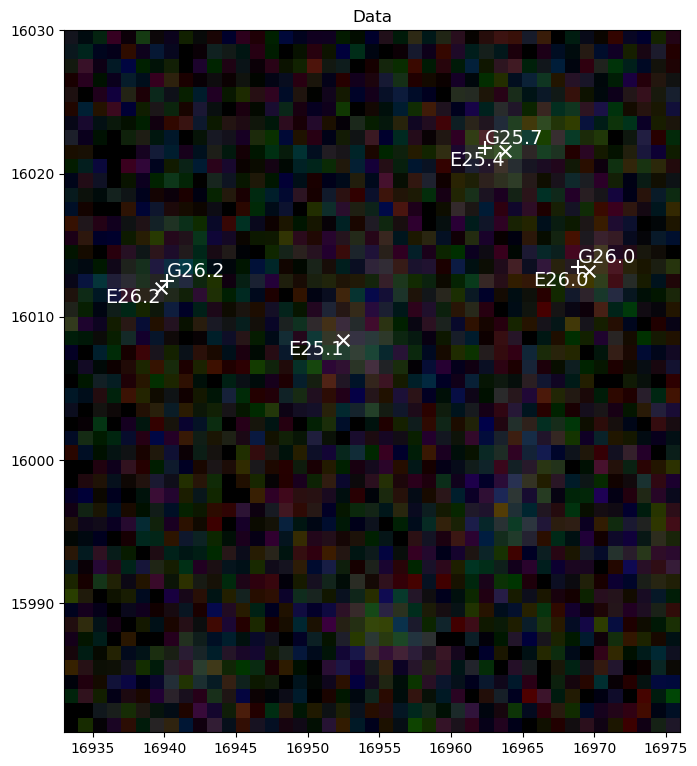

Model: scarlet
idx_child=201 failed to rebuild due to source 3495976385350992127 has invalid flags for fit


In [9]:
# plot a blend - it's faint, there are no nice ways to plot it
kwargs_parent = dict(Q=5, minimum=-0.5, rgb_stretch_auto=False, stretch=8)
kwargs_children = dict(Q=8, minimum=-0.02, rgb_stretch_auto=True)
fig_rgb, ax_rgb, fig_gs, ax_gs = plot_blend(
    rebuilder, 201, kwargs_plot_parent=kwargs_parent, kwargs_plot_children=kwargs_children,
    table_ref_type=CosmosAcsTable, weights=weights,
)

In [10]:
# retrieve the parents
catalog_ref = rebuilder_ref.catalog_multi

Plot blends with bright unmatched HST sources

This section loops through the blends that have an unmatched and bright HST
source in them. The reasons HST sources are unmatched include:
- the nearest HSC source is flagged or has bad photometry
  (the matcher can be configured to only use astrometry)
- the centroids are off by slightly more than the match radius
- the whole blend a mess due to an unmasked trail and/or being near the edge
  of the patch
- actually a genuine undetected blend

{'x': '17863.000', 'y': '18521.000', 'mag_hsc_cmodel': '24.49', 'parent': '3495976385350998757', 'primary': '0', 'ra': '150.254285', 'dec': '2.255765', 'dist (asec)': '0.507'}


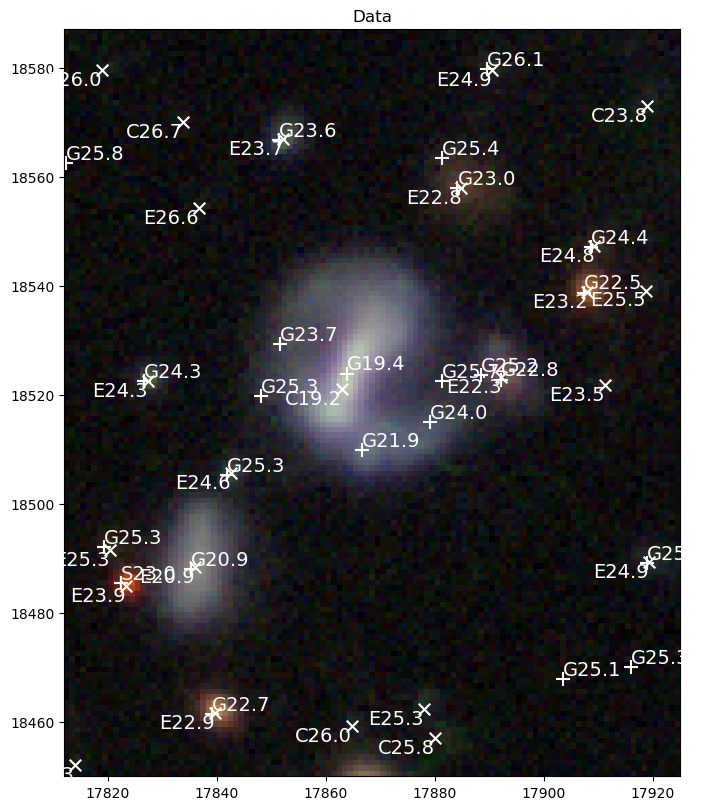

Model: scarlet
idx_child=4768 failed to rebuild due to source 3495976385350998757 has invalid flags for fit
{'x': '17978.070', 'y': '19999.564', 'mag_hsc_cmodel': '24.51', 'parent': '3495976385351002291', 'primary': '0', 'ra': '150.248911', 'dec': '2.324765', 'dist (asec)': '0.108'}


/sdf/group/rubin/sw/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: UserWarning: Warning: converting a masked element to nan.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


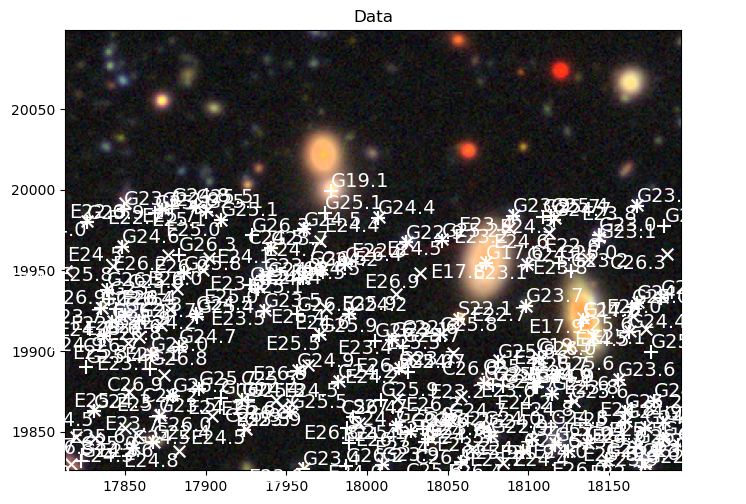

Model: scarlet
idx_child=7192 failed to rebuild due to source 3495976385351002291 has invalid flags for fit
{'x': '17054.611', 'y': '17114.536', 'mag_hsc_cmodel': '26.14', 'parent': '3495976385350995141', 'primary': '1', 'ra': '150.292038', 'dec': '2.190129', 'dist (asec)': '0.649'}


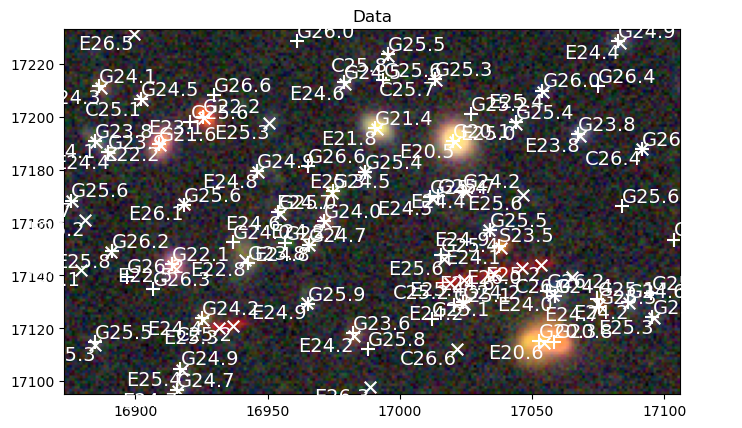

Model: scarlet
idx_child=2294 failed to rebuild due to source 3495976385350995141 has invalid flags for fit
{'x': '17637.000', 'y': '16496.000', 'mag_hsc_cmodel': '23.42', 'parent': '3495976385350993432', 'primary': '0', 'ra': '150.264839', 'dec': '2.161265', 'dist (asec)': '0.724'}


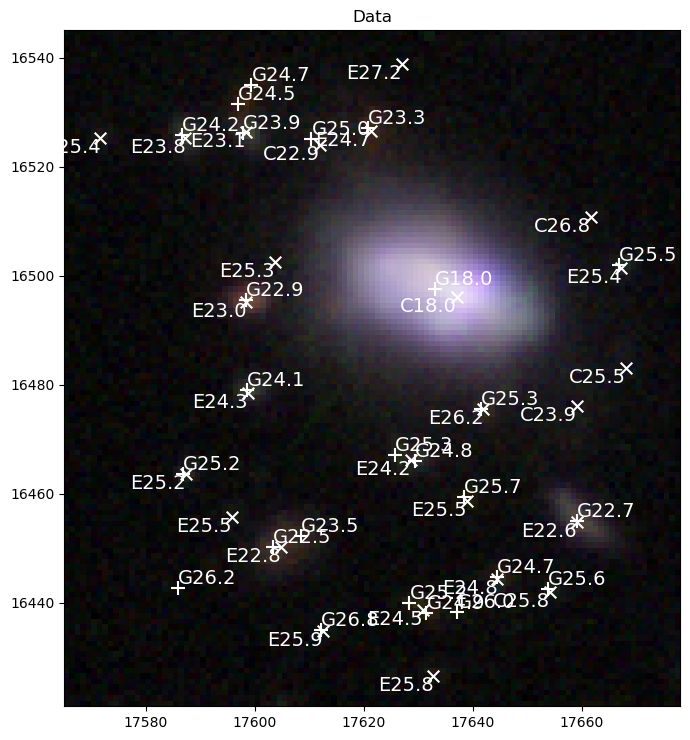

Model: scarlet
idx_child=1110 failed to rebuild due to source 3495976385350993432 has invalid flags for fit
{'x': '16438.130', 'y': '17851.119', 'mag_hsc_cmodel': '24.55', 'parent': '3495976385350997074', 'primary': '1', 'ra': '150.320829', 'dec': '2.224502', 'dist (asec)': '0.815'}


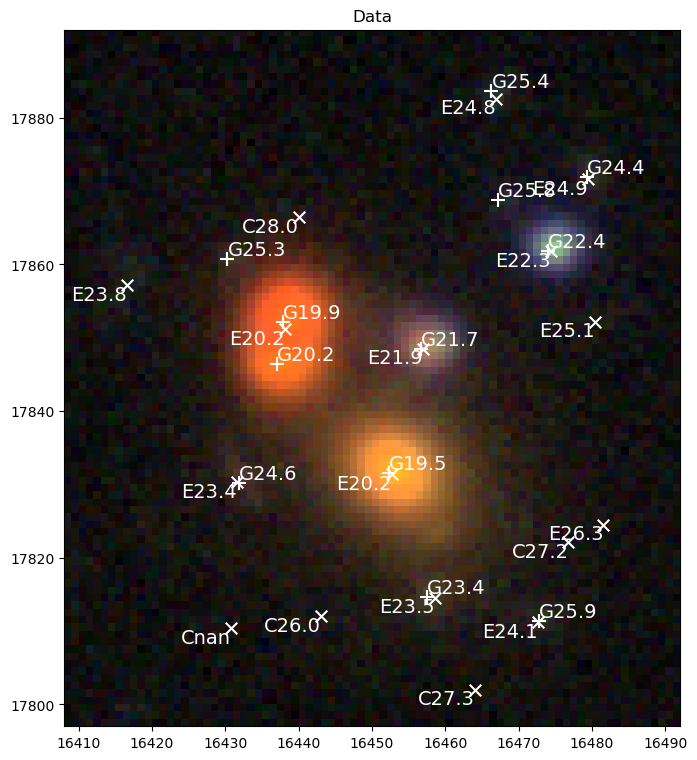

Model: scarlet
idx_child=3611 failed to rebuild due to source 3495976385350997074 has invalid flags for fit


In [11]:
# find and plot bright unmatched HST sources
kwargs_parent = dict(Q=5, minimum=-1, rgb_stretch_auto=True)
kwargs_children = dict(Q=8, minimum=-0.5, rgb_stretch_auto=True)

matched = rebuilder.matches["scarlet"].matches
mag = u.nJy.to(u.ABmag, matched["refcat_flux_auto"])

idx_bright = np.where((matched["refcat_mu_class"] == 1) & (mag < 22) & ~(matched["match_distance"] < 0.5))[0]
idx_parents = defaultdict(list)


def get_info_formatted(info: dict):
    formats = {
        "x": ".3f", "y": ".3f",
        "ra": ".6f", "dec": ".6f",
        "mag_hsc_cmodel": ".2f",
        "parent": "d",
        "primary": "1",
        "dist (asec)": ".3f",
    }
    info_formatted = {
        k: f"{v:{formats[k]}}" for k, v in info.items()
    }
    return info_formatted


for idx in idx_bright:
    ra, dec = (matched[idx][f"refcat_{c}"] for c in ("ra", "dec"))
    # Find the closest object's parent (matched or otherwise)
    ra_meas, dec_meas = (catalog_ref[f"coord_{c}"]*180/math.pi for c in ("ra", "dec"))
    dist = sphdist(ra_meas, dec_meas, ra, dec)
    idx_closest = np.nanargmin(dist)
    closest = catalog_ref[idx_closest]
    parent = closest["parent"]
    idx_parent = np.argwhere(catalog_ref["id"] == parent)[0][0] if parent else idx_closest
    info = {
        "x": closest["slot_Centroid_x"],
        "y": closest["slot_Centroid_y"],
        "mag_hsc_cmodel": u.nJy.to(u.ABmag, closest["modelfit_CModel_instFlux"]),
        "parent": catalog_ref[idx_parent]["id"],
        "primary": closest["detect_isPrimary"],
        "ra": closest["coord_ra"].asDegrees(),
        "dec": closest["coord_dec"].asDegrees(),
        "dist (asec)": dist[idx_closest]*3600,
    }
    idx_parents[idx_parent].append(info)

for idx_parent, infos in idx_parents.items():
    for info in infos:
        print(get_info_formatted(info))
    fig_rgb, ax_rgb, fig_gs, ax_gs = plot_blend(
        rebuilder, idx_parent, kwargs_plot_parent=kwargs_parent, kwargs_plot_children=kwargs_children,
        table_ref_type=CosmosAcsTable, weights=weights,
    )

In [12]:
# load the tile info
idx_parent = 3611
info = idx_parents[idx_parent][0]
ra_last, dec_last = info["ra"], info["dec"]
tiles = tile_table.find_tile_names(ra_last, dec_last)
tile = tile_table.make_tile(tiles[0])

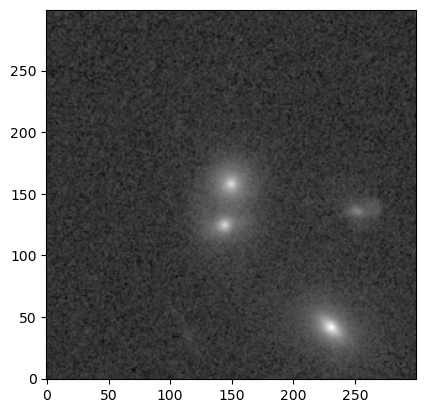

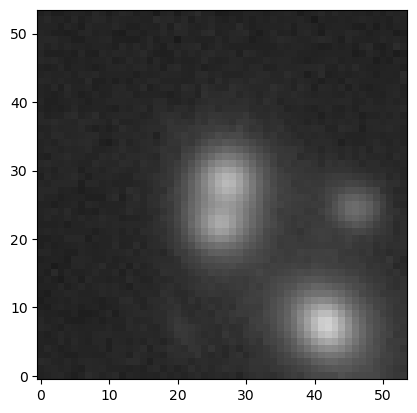

In [13]:
# get HST image and compare to i-band HSC
x_cen_hst, y_cen_hst = tile.wcs.world_to_pixel(SkyCoord(ra_last, dec_last, unit=u.deg))
x_hst, y_hst = int(math.floor(x_cen_hst)), int(math.floor(y_cen_hst))
half_width = 150
cutout = tile.image.data[y_hst - half_width:y_hst + half_width, x_hst - half_width:x_hst + half_width]
plt.imshow(cutout, cmap='gray', norm=ImageNormalize(cutout, stretch=AsinhStretch(0.005)))
plt.show()

half_width_hsc = int(math.ceil(half_width*0.03/0.168))
x_last, y_last = (int(math.floor(info[coord])) for coord in ("x", "y"))
catexp = next(iter(catexp for catexp in rebuilder_ref.catexps if catexp.band == "i"))
cutout_hsc = catexp.exposure[
    x_last - half_width_hsc:x_last + half_width_hsc,
    y_last - half_width_hsc:y_last + half_width_hsc,
]
norm_hsc = ImageNormalize(cutout, stretch=AsinhStretch(0.01), vmin=-0.2, vmax=25)
plt.imshow(cutout_hsc.image.array, cmap='gray', norm=norm_hsc)
plt.show()